# Esercitazione 1
## Derivazione delle curve di possibilità pluviometrica per i dati relativi alla stazione di Venezia

Le curve di possibilità pluviometrica, ci danno informazioni sull'altezza di precipitazione $h$, noti durata $t$ e tempo di ritorno $Tr$. Per ogni durata si cercherà dunque di interpolare i dati a una distribuzione di probabilità, capace di rappresentare la distribuzione incognita. Per questa analisi, si è scelto di utilizzare l'espressione parametrica delle curve di Gumbel:
$$ P[H<h; a,b] = e^{-e-{\frac{h-a}{b}}}$$

Dove $a$ è paramtetro di posizione (moda) e $b$ parametro di forma (media).

Per prima cosa è necessario calcolare i valori di $a$ e $b$ che meglio interpolano la distribuzione di Gumbel.
Per ottenere questo risultato si dovrà calcolare i due parametri tramite:
- il metodo dei momenti
- il metodo della massima verosimiglianza
- il metodo dei minimi quadrati

Grazie al test di Pearson sarà infine possibile scegliere la coppia di parametri migliori e sostituirli in modo da trovare le curve che meglio approssimano i valori dati.

In [28]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt

In [29]:
data = pd.read_csv('PluviometriaVE.txt')

In [30]:
map(datetime,data['anno'])
data=data.set_index('anno')

In [31]:
data

,1h,3h,6h,12h,24h
anno,,,,,
2000,36.2,36.2,62.0,73.2,93.2
2001,37.0,52.8,55.0,69.8,78.8
2002,41.8,55.4,58.2,59.0,60.0
2003,25.8,29.8,31.0,41.0,46.8
2004,21.2,28.0,39.0,45.6,61.6
2005,57.2,60.8,61.0,70.0,90.2
2006,36.0,50.4,57.4,93.6,109.2
2007,65.8,92.4,107.4,113.6,127.4
2008,47.2,49.4,59.6,89.8,102.2


In [32]:
means=data.mean()
means

1h     40.463636
3h     50.154545
6h     57.763636
12h    66.990909
24h    77.781818
dtype: float64

{da qui in poi lui ha messo tutte le varie operazioni tipo per calcolare deviazione standard, etc, non so se serva a qualcosa, magari gli chiediamo lunedì }

Text(0, 0.5, 'Rainfall (mm)')

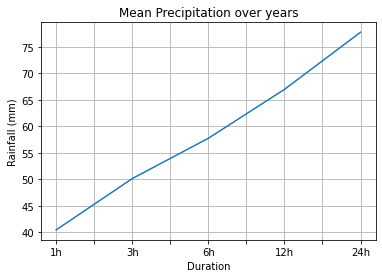

In [33]:
ax=means.plot()
ax.grid(True)
#ax.legend(loc='right')
ax.set_title('Mean Precipitation over years')
ax.set_xlabel('Duration')
ax.set_ylabel('Rainfall (mm)')

In [34]:
variances=data.var()
variances

1h     367.910043
3h     616.464502
6h     728.741472
12h    733.685628
24h    871.009177
dtype: float64

In [35]:
stds=data.std()
stds

1h     19.180981
3h     24.828703
6h     26.995212
12h    27.086632
24h    29.512865
dtype: float64

In [36]:
cv=data.std()/means
cv

1h     0.474030
3h     0.495044
6h     0.467339
12h    0.404333
24h    0.379431
dtype: float64

## Interpolazione delle curve di Gumbel con il metodo dei momenti

Per il metodo dei momenti, la determinazione di a e b nella curva di Gumbel, è possibile tramite la risoluzione del sistema:

\begin{equation}
\left\{
\begin{array}{l}
b \gamma + a = \mu_H \\
\sigma^2_H = b^2  \frac{\pi^2}{6}
\end{array}
\right.
\end{equation}

che quindi vuole:
\begin{equation}
b = \frac{\sqrt{6}}{\pi} \sigma_H
\end{equation}

\begin{equation}
a = \mu_H -\frac{\sqrt{6}\gamma}{\pi} \sigma_H 
\end{equation}

sostituiamo quindi i valori che abbiamo raccolto per le varie durate:

In [37]:
EulerGamma=0.577215664901532860606512090

Il primo coefficiente, che useremo nell'espressione per il calcolo di b sarà

In [38]:
coeff1 = (math.sqrt(6)/math.pi)

Il secondo, presente nell'espressione per il calcolo di a, è pari a quello già calcolato moltiplicato per la costante di Eulero

In [39]:
coeff2= coeff1*EulerGamma

In [40]:
def g(m,s):
    return pd.DataFrame([m-coeff2*s,coeff1*s],index=["a","b"])

In [41]:
ab_m = g(means, stds)
ab_m

,1h,3h,6h,12h,24h
a,31.831174,38.980308,45.614355,54.800484,64.499459
b,14.955350,19.358860,21.048080,21.119360,23.011086


In [42]:
ab_m.to_pickle("ab_m")

In [43]:
from scipy.stats import genextreme,gumbel_r
from numpy import linspace

Definiamo adesso la funzione di Gumbel, come già scritta in precedenza, prendendo i valori di a e b dalle colonne della tabella soprastante

In [44]:
def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-ab_m[col]["a"])/ab_m[col]["b"]))

In [45]:
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

In [46]:
ecdf1h = ECDF(data["1h"])

Prima di interpolare le curve di Gumbel si può controllare quali sono i valori di minimo e di massimo, in modo da poter poi verificare che la curva sia attendibile

In [47]:
min= data.min()[0]

In [48]:
max = data.max()[4]

Le curve potranno quindi prendere valori da 12.0mm a 153mm che sono il minimo che troviamo per la durata di precipitazione più corta (1h) e il massimo per la più lunga (24h)

In [49]:
t_rain=np.linspace(min, max,100)

In [50]:
gb=pd.DataFrame([gumbel(t_rain,ab_m,"1h"),
                 gumbel(t_rain,ab_m,"3h"),
                 gumbel(t_rain,ab_m,"6h"),
                 gumbel(t_rain,ab_m,"12h"),
                 gumbel(t_rain,ab_m,"24h")]).T
gb.index=t_rain
gb.columns=["1h","3h","6h","12h","24h"]
gb

,1h,3h,6h,12h,24h
12.000000,0.023143,0.017780,0.007167,0.000506,0.000056
13.424242,0.032584,0.023662,0.009900,0.000831,0.000101
14.848485,0.044471,0.030859,0.013390,0.001319,0.000175
16.272727,0.059005,0.039494,0.017756,0.002033,0.000294
17.696970,0.076302,0.049668,0.023114,0.003045,0.000479
...,...,...,...,...,...
147.303030,0.999557,0.996292,0.992055,0.987553,0.973004
148.727273,0.999597,0.996555,0.992573,0.988360,0.974604
150.151515,0.999634,0.996799,0.993057,0.989115,0.976109
151.575758,0.999667,0.997026,0.993510,0.989821,0.977527


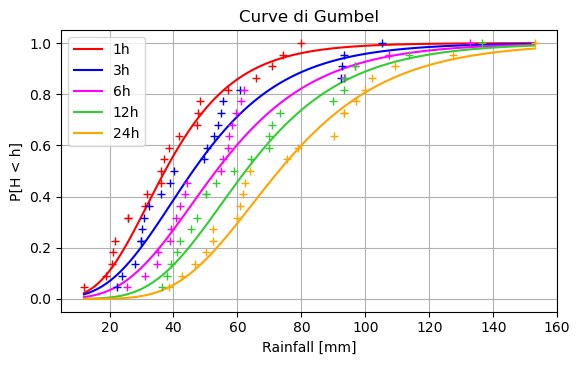

In [170]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 
plt.style.use('default')
ax=gb.plot(color=["red","blue","magenta","limegreen","orange"])
ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'+',c="red", label="1h",markersize=6) 
data3h=data["3h"]
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"+",c="blue", label="3h",markersize=6)
data6h=data["6h"]
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"+",c="magenta", label="6h",markersize=6)
data12h=data["12h"]
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"+",c="limegreen", label="12h",markersize=6)
data24h=data["24h"]
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"+",c="orange", label="24h",markersize=6)
ax.set_title('Curve di Gumbel')
ax.set_xlabel('Rainfall [mm]')
ax.set_ylabel('P[H < h]')
ax.set_aspect(80)
plt.grid()

Dal grafico è evidente come l'interpolazione dei dati, soprattutto per le precipitazioni di durata pari a 6h e 24h, sia molto approssimativa.
Sia dai punti sul grafico sia dati dati esposti prima si può inoltre constatare che numerose precipitazioni per quelle durate sono caratterizzata da un'intensità di circa 60mm.